<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/batch-regression-gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient of Cost on a Batch of Data

In this notebook, we expand on the partial derivative calculus of the [*Single Point Regression Gradient* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/single-point-regression-gradient.ipynb) to: 

* Calculate the gradient of mean squared error on a batch of data
* Visualize gradient descent in action

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

In [3]:
def regression(my_x, my_m, my_b):
    return my_x*my_m + my_b

In [4]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

**Step 1**: Forward pass

In [5]:
yhats = regression(xs, m, b)
yhats

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

As in the [*Regression in PyTorch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb), let's use mean squared error, which averages quadratic cost across multiple data points: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [6]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [7]:
C = mse(yhats, ys)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [8]:
C.backward()

In [9]:
m.grad

tensor([36.3050])

In [10]:
b.grad

tensor([6.2650])

**Return to *Calculus II* slides here to derive $\frac{\partial C}{\partial m}$ and $\frac{\partial C}{\partial b}$.**

$$ \frac{\partial C}{\partial m} = \frac{2}{n} \sum (\hat{y}_i - y_i) \cdot x_i $$

In [11]:
2*1/len(ys)*torch.sum((yhats - ys)*xs)

tensor(36.3050, grad_fn=<MulBackward0>)

$$ \frac{\partial C}{\partial b} = \frac{2}{n} \sum (\hat{y}_i - y_i) $$

In [12]:
2*1/len(ys)*torch.sum(yhats - ys)

tensor(6.2650, grad_fn=<MulBackward0>)

We don't need to explicitly create a standalone $\nabla C$ object for the remainder of the code in this notebook to run, but let's create it for fun anyway: 

In [13]:
nabla_C = torch.tensor([m.grad.item(), b.grad.item()]).T
nabla_C

tensor([36.3050,  6.2650])

Let's visualize the most pertinent metrics in a single plot: 

In [14]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):
    
    title = 'Cost = {}'.format('%.3g' % my_C.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % my_m.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % my_b.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % my_m.item())        
        ylabel = 'b = {}'.format('%.3g' % my_b.item())
    
    fig, ax = plt.subplots()
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = my_m*x_min + my_b, my_m*x_max + my_b

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

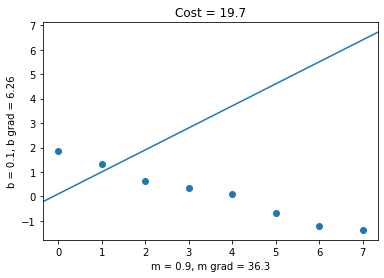

In [15]:
labeled_regression_plot(xs, ys, m, b, C)

**Step 4**: Gradient descent

$\frac{\partial C}{\partial m} = 36.3$ indicates that an increase in $m$ corresponds to a large increase in $C$. 

Meanwhile, $\frac{\partial C}{\partial b} = 6.26$ indicates that an increase in $b$ also corresponds to an increase in $C$, though much less so than $m$.

In the first round of training, the lowest hanging fruit with respect to reducing cost $C$ is therefore to decrease the slope of the regression line, $m$. There will also be a relatively small decrease in the $y$-intercept of the line, $b$. 

In [16]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [17]:
optimizer.step()

In [18]:
C = mse(regression(xs, m, b), ys)

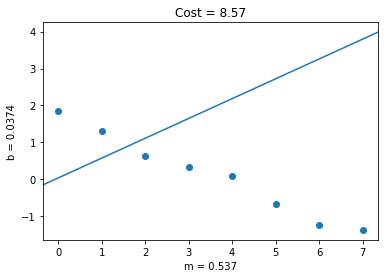

In [19]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False) # Gradient of C hasn't been recalculated

### Rinse and Repeat

Observe further rounds of training: 

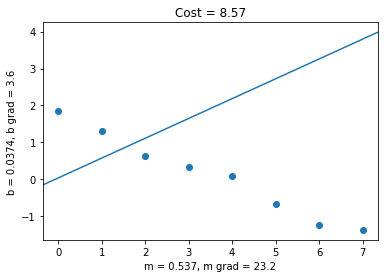

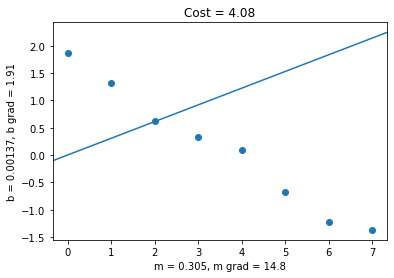

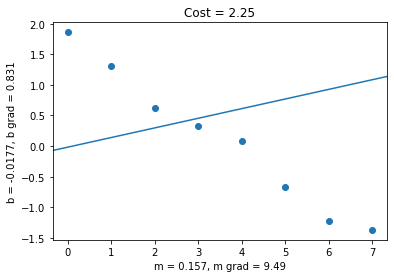

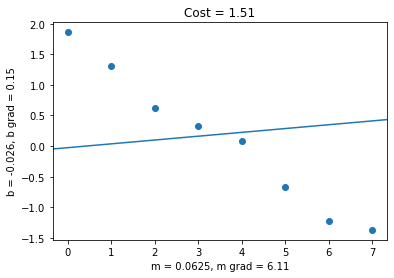

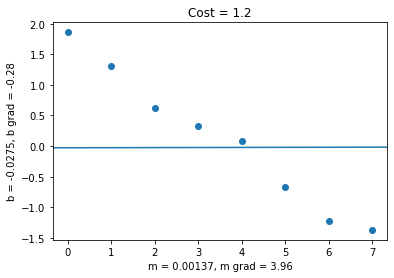

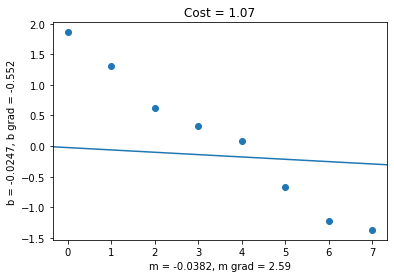

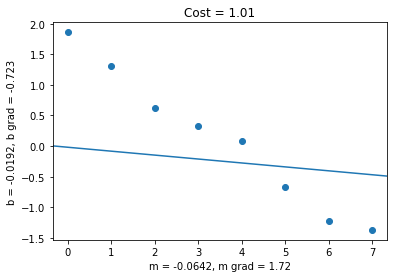

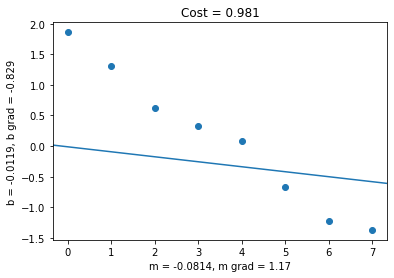

In [20]:
epochs = 8
for epoch in range(epochs): 
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhats = regression(xs, m, b) # Step 1
    C = mse(yhats, ys) # Step 2
    
    C.backward() # Step 3
    
    labeled_regression_plot(xs, ys, m, b, C)
    
    optimizer.step() # Step 4

In later rounds of training, after the model's slope $m$ has become closer to the slope represented by the data, $\frac{\partial C}{\partial b}$ becomes negative, indicating an inverse relationship between $b$ and $C$. Meanwhile, $\frac{\partial C}{\partial m}$ remains positive. 

This combination directs gradient descent to simultaneously adjust the $y$-intercept $b$ upwards and the slope $m$ downwards in order to reduce cost $C$ and, ultimately, fit the regression line snugly to the data. 